# **Create datasets from bSSFP at 0.55T**
#### DATA
The CINE data was acquired for different slices in a 0.55T scanner

## **libraries**

In [1]:
# basic libraries
import numpy as onp
import jax.numpy as np 
import matplotlib.pyplot as plt  
import os
# bart
from inrmri.bart import bart_acquisition_from_arrays

In [2]:
from inrmri.utils_rdls import preprocess_data, get_csm_format
from inrmri.utils_rdls import plot_angles_and_times_from_xdata, balance_spokes_duplicating
from inrmri.utils_rdls import plot_traj, plot_kdata, plot_csm, plot_zoom_images

In [3]:
from inrmri.utils_rdls import load_acq_data, get_inf_about_data, filtering_spokes, plot_spokes_and_hb, sort_data_by_bin, get_csm_format, preprocess_data
from inrmri.utils_rdls import get_exp_weight_descrite, plot_angles_and_times_from_xdata, balance_spokes_duplicating

In [4]:
from inrmri.utils_rdls import create_folder, save_frames_as_gif_with_pillow

## **1. - Base data**

In [5]:
# input folders
volunteer_name      = 'FH'
slice_num           = 1 # 1, 2, o 3
nslices             = 8
eliminated_spokes   = 20
# parameters
nbins                 = 30
# computation folders
bart_files_folder     = '/mnt/workspace/datasets/pulseqCINE/bart_files/'
# output folder
dataset_name          = 'DATA_0.55T'
base_folder           = '/mnt/workspace/datasets/pulseqCINE/' + dataset_name + '/' + volunteer_name + '/'
train_data_folder     = base_folder + '/traindata/'
recons_folder         = base_folder + '/recons/' 
raw_data_folder       = base_folder + '/datasets/'

In [6]:
# reset folder
create_folder(bart_files_folder, reset=True)
# create folder
create_folder(train_data_folder, reset=False)
create_folder(recons_folder, reset=False)

In [7]:
dataset_name        = 'slice_' + str(slice_num) +'_' + str(nslices) +'_nbins' + str(nbins)
dataset_name_gt     = 'slice_' + str(slice_num) +'_' + str(nslices) +'_nbins' + str(nbins) + '_gt'
dataset_recon_folder      = recons_folder + dataset_name + '/'
path_save                 = train_data_folder + dataset_name + '.npz'

In [8]:
path2folder = raw_data_folder + dataset_name + '.mat'
bins, cbins, kdata, ktraj = load_acq_data(path2folder)

In [9]:
n_spokes, n_readout, n_coils, n_bins, n_dims = get_inf_about_data(ktraj, kdata, cbins)

n_spokes =  263
n_readout =  256
n_coils =  15
n_bins =  30
n_dims =  2


In [10]:
average_n_spokes_per_frame = n_spokes/n_bins
print('average number of spokes per frame: ' , average_n_spokes_per_frame)

average number of spokes per frame:  8.766666666666667


In [11]:
average_acceleration_factor = n_readout/average_n_spokes_per_frame
print('average acceleration factor: ' , average_acceleration_factor)

average acceleration factor:  29.201520912547526


## **1.1 Load Data**

In [12]:
path2folder = raw_data_folder + dataset_name + '.mat'
bins, cbins, kdata, ktraj = load_acq_data(path2folder)
n_spokes, n_readout, n_coils, n_bins, n_dims = get_inf_about_data(ktraj, kdata, cbins)

n_spokes =  263
n_readout =  256
n_coils =  15
n_bins =  30
n_dims =  2


In [13]:
path2folder_gt = raw_data_folder + dataset_name_gt + '.mat'
bins_gt, cbins_gt, kdata_gt, ktraj_gt = load_acq_data(path2folder_gt)
n_spokes_gt, n_readout_gt, n_coils_gt, n_bins_gt, n_dims_gt = get_inf_about_data(ktraj_gt, kdata_gt, cbins_gt)

n_spokes =  2527
n_readout =  256
n_coils =  15
n_bins =  30
n_dims =  2


## **1.2 Preprocess data**

### **1.2.1 - Filtration of not used spokes**
Spokes not asigned to bins are filtered

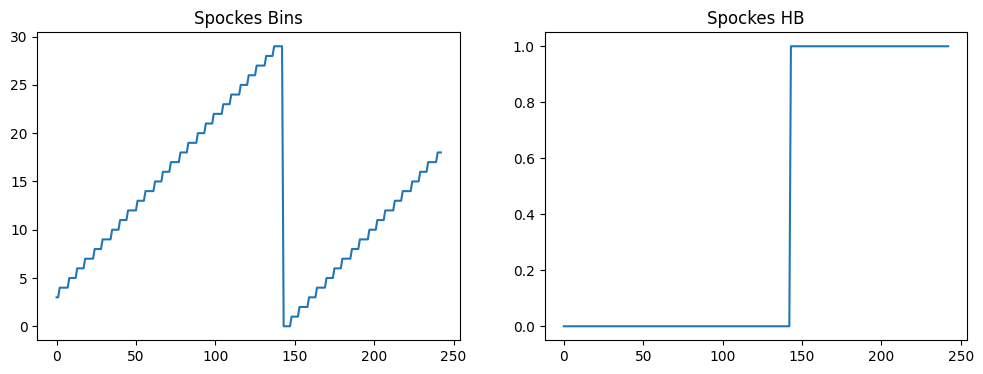

In [14]:
bins_filtered, kdata_filtered, ktraj_filtered, hb_filtered = filtering_spokes(eliminated_spokes, bins, kdata, ktraj)
plot_spokes_and_hb(bins_filtered, hb_filtered)

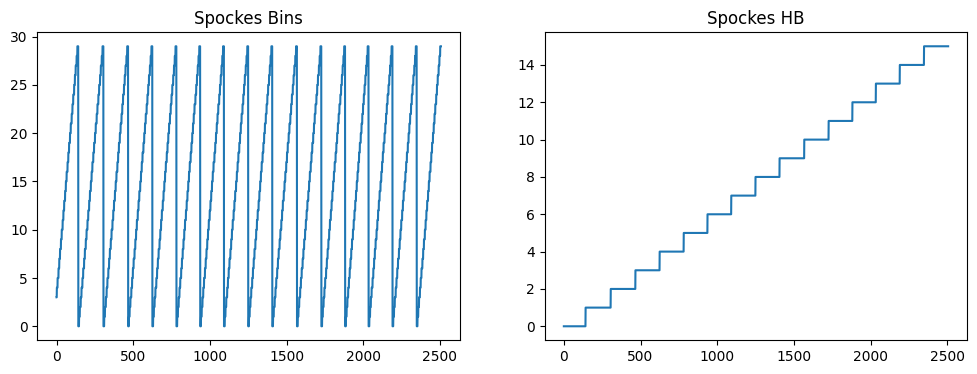

In [15]:
bins_filtered_gt, kdata_filtered_gt, ktraj_filtered_gt, hb_filtered_gt = filtering_spokes(eliminated_spokes, bins_gt, kdata_gt, ktraj_gt)
plot_spokes_and_hb(bins_filtered_gt, hb_filtered_gt)

### **1.2.3 - Reorder the data**
The bins are sorted, while the hb are not in the correct order. This is the order that matter for the model training.

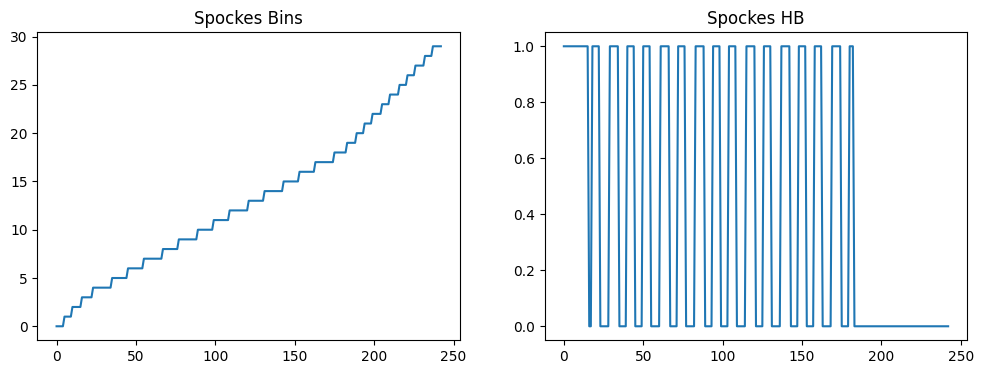

In [16]:
kdata_sorted, ktraj_sorted, bins_sorted, hb_sorted = sort_data_by_bin(bins_filtered, kdata_filtered, ktraj_filtered, hb_filtered)
plot_spokes_and_hb(bins_sorted, hb_sorted)

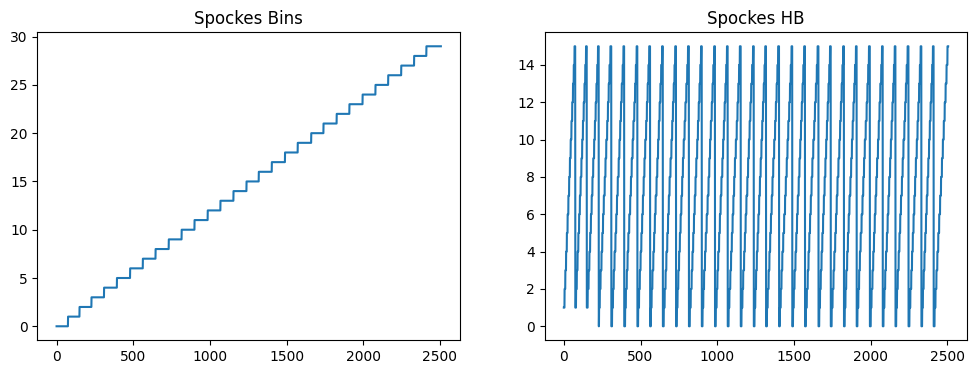

In [17]:
kdata_sorted_gt, ktraj_sorted_gt, bins_sorted_gt, hb_sorted_gt = sort_data_by_bin(bins_filtered_gt, kdata_filtered_gt, ktraj_filtered_gt, hb_filtered_gt)
plot_spokes_and_hb(bins_sorted_gt, hb_sorted_gt)

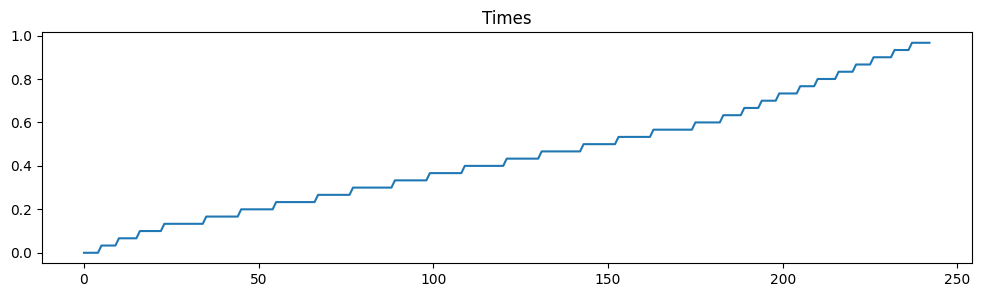

In [18]:
times = onp.array(bins_sorted)/n_bins 
fig, axes = plt.subplots(1, 1, figsize=(12, 3))
axes.plot(times)
axes.set_title("Times")
plt.show()

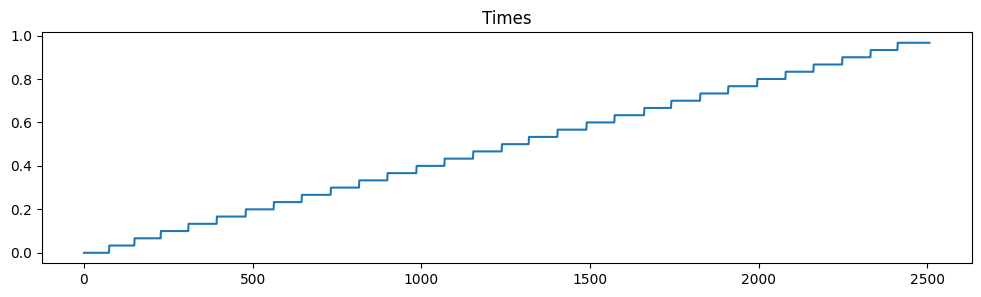

In [19]:
times_gt = onp.array(bins_sorted_gt)/n_bins_gt 
fig, axes = plt.subplots(1, 1, figsize=(12, 3))
axes.plot(times_gt)
axes.set_title("Times")
plt.show()

### **1.4 - Coil estimation**

2025-04-20 21:31:56.742252: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Est. image size: 256x256x1
Done.
Done.


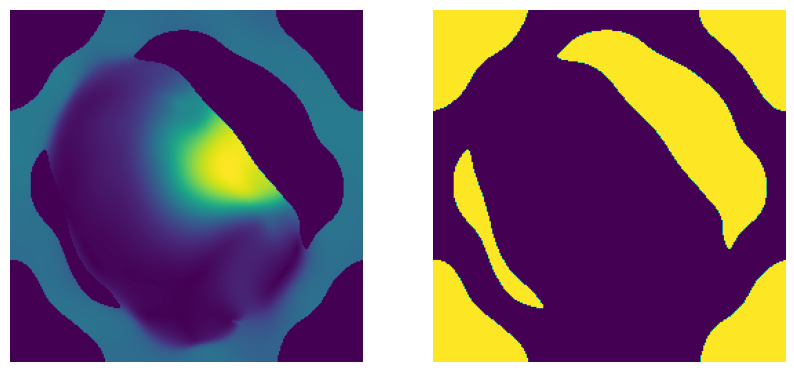

In [20]:
csm, hollow_mask, bac_csm = get_csm_format(ktraj_sorted, kdata_sorted, bart_files_folder, dataset_name)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(onp.abs(csm[0,:,:]))
axes[0].axis('off')  # Turn off the axis for the first image
axes[1].imshow(onp.abs(hollow_mask))
axes[1].axis('off')  # Turn off the axis for the second image
plt.show()

Est. image size: 256x256x1
Done.
Done.


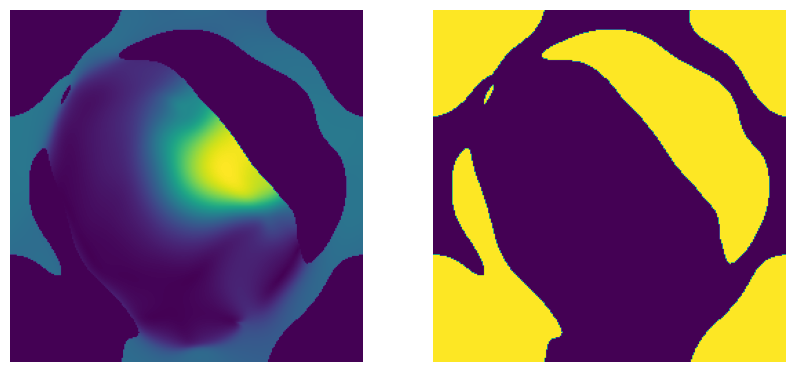

In [21]:
csm_gt, hollow_mask_gt, bac_csm_gt = get_csm_format(ktraj_sorted_gt, kdata_sorted_gt, bart_files_folder, dataset_name_gt)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(onp.abs(csm_gt[0,:,:]))
axes[0].axis('off')  # Turn off the axis for the first image
axes[1].imshow(onp.abs(hollow_mask_gt))
axes[1].axis('off')  # Turn off the axis for the second image
plt.show()

# **2 .- TD-DIP dataset**

## **2.1 .- Preprocess data**

The trajectories are not centered!


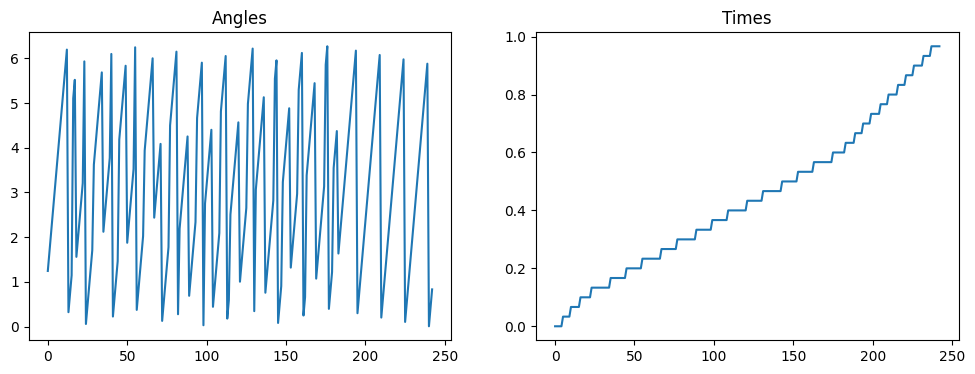

In [22]:
Y_data, X_data, spclim = preprocess_data(times, kdata_sorted, ktraj_sorted)
plot_angles_and_times_from_xdata(X_data)

The trajectories are not centered!


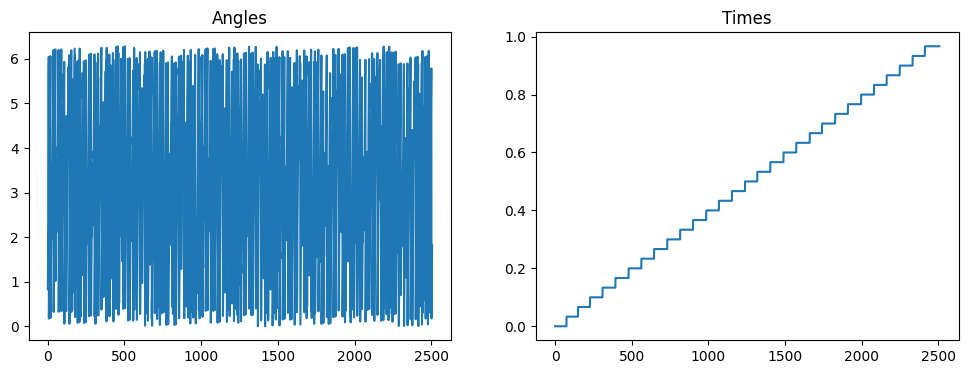

In [23]:
Y_data_gt, X_data_gt, spclim_gt = preprocess_data(times_gt, kdata_sorted_gt, ktraj_sorted_gt)
plot_angles_and_times_from_xdata(X_data_gt)

# **3 .- GRASP and iterative-SENSE reconstructions**

In [24]:
def recon_bart(times, kdata_sorted, ktraj_sorted, dataset_name):
    ktraj_b, kdata_b, time_b = balance_spokes_duplicating(times, kdata_sorted, ktraj_sorted)
    # grasp
    bac_name_grasp = dataset_name + '_grasp_b'
    bac_grasp = bart_acquisition_from_arrays(ktraj_b, kdata_b, bart_files_folder, bac_name_grasp)
    iters = 100
    lagrangian_value = 5.
    lambda_value = 0.01
    grasp_exp_name = bac_name_grasp + str(iters) + '_lagrangian' + str(lagrangian_value).replace(".", "_") + '_lambda' + str(lambda_value).replace(".", "_")
    
    recon_grasp = bac_grasp.calculate_bart_reco_with_external_csmap(bac_csm, grasp_exp_name, lmbda = lambda_value, lagrangian = lagrangian_value, iters = iters)
    recon_grasp = recon_grasp.reshape((recon_grasp.shape[0],recon_grasp.shape[1],recon_grasp.shape[-1]))
    bac_name_sense = dataset_name + '_sense_b'
    # selse
    recon_sense = bac_grasp.make_sense_reconstruction( bac_csm.csmappath(), bac_name_sense)
    recon_sense = recon_sense.reshape((recon_sense.shape[0],recon_sense.shape[1],recon_sense.shape[-1]))
    return recon_grasp, recon_sense

## 3.1 GRASP recon of undersampled data

In [25]:
recon_grasp, recon_sense = recon_bart(times, kdata_sorted, ktraj_sorted, dataset_name)

(256, 243, 15) (243, 256, 2)
[  1 256  12  15   1   1   1   1   1   1  30   1   1   1   1   1 ]
[256 256   1  15   1   1   1   1   1   1  30   1   1   1   1   1 ]
TV regularization: 0.010000
Regularization terms: 1, Supporting variables: 0
ADMM
Total Time: 88.177715
[  1 256  12  15   1   1   1   1   1   1  30   1   1   1   1   1 ]
[256 256   1  15   1   1   1   1   1   1  30   1   1   1   1   1 ]
Regularization terms: 0, Supporting variables: 0
conjugate gradients
Total Time: 23.362840


In [26]:
recon_grasp_gt, recon_sense_gt = recon_bart(times_gt, kdata_sorted_gt, ktraj_sorted_gt, dataset_name_gt)

(256, 2507, 15) (2507, 256, 2)
[  1 256  95  15   1   1   1   1   1   1  30   1   1   1   1   1 ]
[256 256   1  15   1   1   1   1   1   1  30   1   1   1   1   1 ]
TV regularization: 0.010000
Regularization terms: 1, Supporting variables: 0
ADMM
Total Time: 94.099211
[  1 256  95  15   1   1   1   1   1   1  30   1   1   1   1   1 ]
[256 256   1  15   1   1   1   1   1   1  30   1   1   1   1   1 ]
Regularization terms: 0, Supporting variables: 0
conjugate gradients
Total Time: 23.799107


### **4.3. - PLOT**

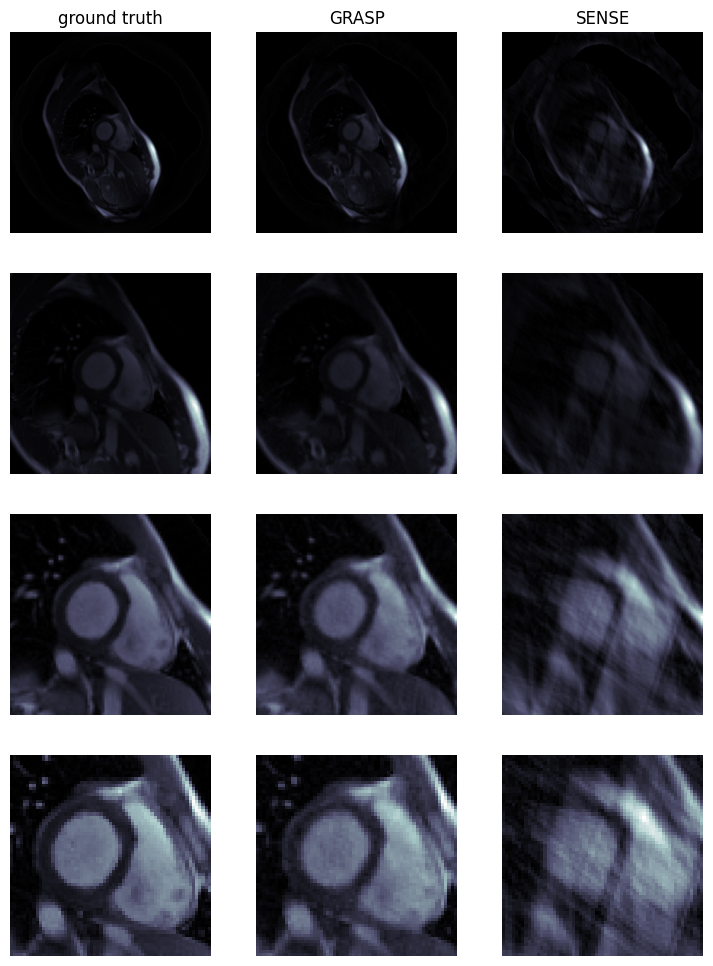

In [27]:
array_images = [recon_grasp_gt,recon_grasp,recon_sense]
array_names = ['ground truth', 'GRASP', 'SENSE']
plot_zoom_images(array_images, array_names, frame_to_show=0, iterative_zoom=4)

## **5 - Save**

### **Data from balancing**

In [28]:
Y_data.shape, X_data.shape, spclim, csm.shape

((243, 15, 256, 1), (243, 2), Array(0.49999955, dtype=float32), (15, 256, 256))

In [29]:
onp.savez(path_save, Y_data=Y_data, X_data=X_data, csm=csm, hollow_mask=hollow_mask, spclim=spclim, recon_grasp=recon_grasp, recon_sense=recon_sense, recon_fs=recon_grasp_gt)

### **Save recons**

#### **Images and Gifs**

In [30]:
recon_grasp_cropped = recon_grasp[recon_grasp.shape[0]//4:3*recon_grasp.shape[0]//4,recon_grasp.shape[1]//4:3*recon_grasp.shape[1]//4,:]
recon_sense_cropped = recon_sense[recon_sense.shape[0]//4:3*recon_sense.shape[0]//4,recon_sense.shape[1]//4:3*recon_sense.shape[1]//4,:]
recon_grasp_gt_cropped = recon_grasp_gt[recon_grasp_gt.shape[0]//4:3*recon_grasp_gt.shape[0]//4,recon_grasp_gt.shape[1]//4:3*recon_grasp_gt.shape[1]//4,:]

In [31]:
save_frames_as_gif_with_pillow(dataset_recon_folder, recon_grasp_cropped / onp.max(onp.abs(recon_grasp_cropped)), filename='GRASP', vmax=1, saturation=0.8, fps=30)
save_frames_as_gif_with_pillow(dataset_recon_folder, recon_sense_cropped / onp.max(onp.abs(recon_sense_cropped)), filename='SENSE', vmax=1, saturation=0.8, fps=30)
save_frames_as_gif_with_pillow(dataset_recon_folder, recon_grasp_gt_cropped / onp.max(onp.abs(recon_grasp_gt_cropped)), filename='FS', vmax=1, saturation=0.8, fps=30)